In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import warnings


## 1. Data Preparation - Housing Prices
Convert quarterly house price data to annual averages


In [2]:
warnings.filterwarnings('ignore')

# Load housing price data
hp_df = pd.read_excel("../data/housing/land-registry-house-prices-ward.xls", sheet_name="Median")

# Define years of interest
years = range(2013, 2018)

# Process housing prices
hp_data = []
for year in years:
    # Get all quarterly columns for the year
    cols = [f"Year ending Mar {year}",
            f"Year ending Jun {year}",
            f"Year ending Sep {year}",
            f"Year ending Dec {year}"]

    # Clean and convert to numeric
    temp = hp_df[["New code", "Ward name", "Borough name"] + cols]
    temp[cols] = temp[cols].replace({'-': np.nan, ',': ''}, regex=True).astype(float)

    # Calculate annual mean
    temp["Mean_Price"] = temp[cols].mean(axis=1)
    temp["Year"] = year

    hp_data.append(temp[["New code", "Ward name", "Borough name", "Year", "Mean_Price"]])

hp_annual = pd.concat(hp_data)


## 2. Burglary Data Processing
Calculate burglary percentage at ward level


In [3]:
# Load and process burglary data
burglary_counts = []
burglary = pd.read_csv("../data/residential_burglary.csv")

for year in years:
    yearly_burglaries = burglary[burglary["Year"] == year]

    # Filter and count burglaries at ward level
    yearly_counts = yearly_burglaries.groupby("Ward Code").size().reset_index(name="Burglary_Count")

    # Calculate percentage
    total_burglaries = yearly_counts["Burglary_Count"].sum()
    yearly_counts["Burglary_Pct"] = (yearly_counts["Burglary_Count"] / total_burglaries) * 100
    yearly_counts["Year"] = year

    burglary_counts.append(yearly_counts)

burglary_df = pd.concat(burglary_counts)


## 3. Data Merging
 Combine housing prices and burglary data


In [4]:
# Merge datasets
merged = pd.merge(
    hp_annual,
    burglary_df,
    left_on=["New code", "Year"],
    right_on=["Ward Code", "Year"],
    how="inner"
)

# Cleanup
merged = merged.dropna(subset=["Mean_Price", "Burglary_Pct"])
merged = merged.rename(columns={"New code": "Ward_Code"})


 ## 4. Advanced Correlation Analysis


In [5]:


# Initialize results storage
correlation_results = []

# Yearly analysis
for year in years:
    year_data = merged[merged["Year"] == year]

    # Calculate different correlation measures
    pearson = pearsonr(year_data["Mean_Price"], year_data["Burglary_Pct"])
    spearman = spearmanr(year_data["Mean_Price"], year_data["Burglary_Pct"])
    kendall = kendalltau(year_data["Mean_Price"], year_data["Burglary_Pct"])

    correlation_results.append({
        "Year": year,
        "Pearson_r": pearson[0],
        "Pearson_p": pearson[1],
        "Spearman_rho": spearman[0],
        "Spearman_p": spearman[1],
        "Kendall_tau": kendall[0],
        "Kendall_p": kendall[1]
    })

# Convert to DataFrame
corr_df = pd.DataFrame(correlation_results)


 ## 5. Visualization


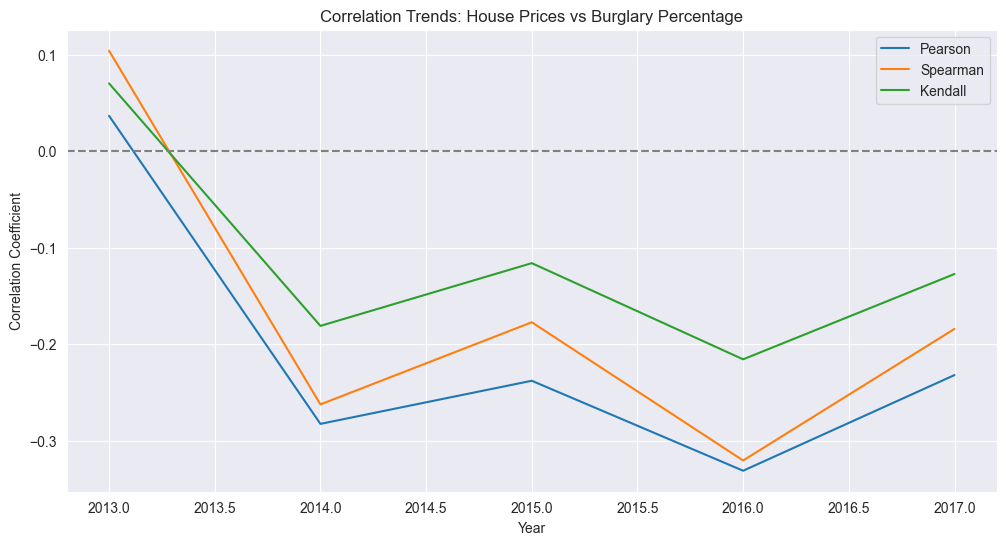

In [6]:
# Temporal trend of correlations
plt.figure(figsize=(12, 6))
sns.lineplot(data=corr_df, x="Year", y="Pearson_r", label="Pearson")
sns.lineplot(data=corr_df, x="Year", y="Spearman_rho", label="Spearman")
sns.lineplot(data=corr_df, x="Year", y="Kendall_tau", label="Kendall")
plt.title("Correlation Trends: House Prices vs Burglary Percentage")
plt.ylabel("Correlation Coefficient")
plt.axhline(0, color="gray", linestyle="--")
plt.legend()
plt.show()


 ## 6. Regression Analysis


In [7]:
# Mixed effects model
mixed_model = smf.mixedlm(
    "Burglary_Pct ~ Mean_Price",
    data=merged,
    groups=merged["Ward_Code"]
).fit()

print(mixed_model.summary())

warnings.filterwarnings('default')


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Burglary_Pct
No. Observations: 294     Method:             REML        
No. Groups:       59      Scale:              0.0019      
Min. group size:  4       Log-Likelihood:     407.5059    
Max. group size:  5       Converged:          Yes         
Mean group size:  5.0                                     
-----------------------------------------------------------
              Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept     0.122     0.016  7.440  0.000   0.090   0.154
Mean_Price    0.000     0.000  2.280  0.023   0.000   0.000
Group Var     0.005     0.029                              

